<a href="https://colab.research.google.com/github/donggrant/sign-language-interface/blob/master/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Lambda ,Dense ,Flatten ,Dropout
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2

In [ ]:
!wget https://github.com/mon95/Sign-Language-and-Static-gesture-recognition-using-sklearn/raw/master/Dataset.zip
!unzip Dataset.zip

--2022-04-15 15:01:26--  https://github.com/mon95/Sign-Language-and-Static-gesture-recognition-using-sklearn/raw/master/Dataset.zip
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mon95/Sign-Language-and-Static-gesture-recognition-using-sklearn/master/Dataset.zip [following]
--2022-04-15 15:01:27--  https://raw.githubusercontent.com/mon95/Sign-Language-and-Static-gesture-recognition-using-sklearn/master/Dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33742153 (32M) [application/zip]
Saving to: ‘Dataset.zip’

Dataset.zip         100%[===================>]  32.18M   113MB/s    in 0.3s 

In [ ]:
from PIL import Image
path = 'Dataset/'
list_of_files = list(filter(lambda f: '.jpg' in f[0],[ (file, os.sep.join((dir, file)))
                       for (dir,dirs,files) in os.walk(path)
                       for file in files]))
from keras.preprocessing.image import load_img
X = np.asarray(list(map(lambda k: np.asarray(Image.open(k[1])), list_of_files)))
y = np.asarray(list(map(lambda k: k[0][:1], list_of_files)))

In [ ]:
# Augmentations
def augment(image):
  image = tf.image.random_brightness(image, max_delta=0.2)
  image = tf.image.random_contrast(image, 0.5, 1)
  image = tf.keras.preprocessing.image.random_rotation(image, 20, row_axis=1,col_axis=2,channel_axis=0,
    fill_mode='nearest',cval=0.0,interpolation_order=1)
  image = tf.keras.preprocessing.image.random_shear(image, 20,row_axis=1,col_axis=2,channel_axis=0,
    fill_mode='nearest',cval=0.0,interpolation_order=1)
  return image

plt.imshow(augment(X[320]))

NameError: ignored

In [ ]:

len(X), len(y)

(1680, 1680)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y' ]
y_bin = le.fit(class_names)
y = y_bin.fit_transform(y)

from sklearn.model_selection import train_test_split
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size = 0.4, random_state = 12345)
X_eval, X_test, y_eval, y_test = train_test_split(X_valtest, y_valtest, test_size = 0.5, random_state = 12345)

In [ ]:
train_n = len(X_train)
test_n = len(X_test)

print("Number of training images: " , train_n)
print("Number of testing images: ", test_n)

eval_n = len(X_eval)
print("Number of evaluation images: ", eval_n)

Number of training images:  1008
Number of testing images:  336
Number of evaluation images:  336


In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_eval = to_categorical(y_eval)

In [ ]:
print(y_train[0])
print(len(y_train[0]))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
24


In [ ]:
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0
X_eval = X_eval.astype('float32')/255.0

In [ ]:
image_height = 240
image_width = 320

#Initialising vgg16 
classifier_vgg16 = VGG16(input_shape= (image_height,image_width,3),include_top=False,weights='imagenet')
#Initialising resnet50 
classifier_resnet = ResNet50(input_shape=(image_height,image_width,3),include_top=False,weights='imagenet')

#don't train existing weights for vgg16
for layer in classifier_vgg16.layers:
    layer.trainable = False

#don't train existing weights for resnet50
for layer in classifier_resnet.layers:
    layer.trainable = False

94781440/94765736 [==============================] - 2s 0us/step


In [ ]:
#VGG16
classifier1 = classifier_vgg16.output#head mode
classifier1 = Flatten()(classifier1)#adding layer of flatten
classifier1 = Dense(units=256, activation='relu')(classifier1)
classifier1 = Dropout(0.6)(classifier1)
classifier1 = Dense(units=24, activation='softmax')(classifier1)

model = Model(inputs = classifier_vgg16.input , outputs = classifier1)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#resnet50
classifier2 = classifier_resnet.output#head mode
classifier2 = Flatten()(classifier2)#adding layer of flatten
classifier2 = Dropout(0.6)(classifier2)
classifier2 = Dense(units=24, activation='softmax')(classifier2)

model2 = Model(inputs = classifier_resnet.input , outputs = classifier2)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#fit the model
#it will take some time to train
#vgg16
history = model.fit(X_train, y_train, epochs =60, batch_size = 64,validation_data=(X_test,y_test))

Epoch 1/60
16/16 [==============================] - ETA: 0s - loss: 4.1152 - accuracy: 0.0466 

KeyboardInterrupt: ignored

In [ ]:
#fit the model
#resnet50
history2 = model2.fit(X_train, y_train, epochs =100, batch_size = 64,validation_data=(X_test,y_test))

In [ ]:
# Accuracy of VGG16
score = model.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')
score = model.evaluate(x = X_eval, y = y_eval, verbose = 0)
print('Accuracy for evaluation images:', round(score[1]*100, 3), '%')

Accuracy for test images: 92.262 %
Accuracy for evaluation images: 92.56 %


In [ ]:
# Accuracy of RESNET50
score = model2.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')
score = model2.evaluate(x = X_eval, y = y_eval, verbose = 0)
print('Accuracy for evaluation images:', round(score[1]*100, 3), '%')

Camera Testing

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


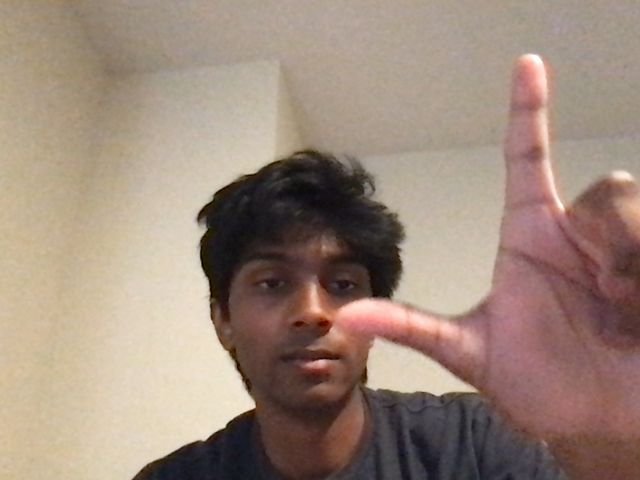

[[[166 147 117]
  [166 147 117]
  [168 149 119]
  ...
  [159 148 130]
  [164 153 135]
  [167 156 138]]

 [[167 147 119]
  [163 143 115]
  [165 146 118]
  ...
  [158 146 130]
  [162 151 134]
  [165 153 136]]

 [[168 150 125]
  [161 144 118]
  [164 146 121]
  ...
  [160 148 134]
  [163 151 137]
  [164 152 138]]

 ...

 [[206 187 147]
  [205 186 146]
  [204 185 145]
  ...
  [106  68  57]
  [105  69  57]
  [105  69  57]]

 [[206 187 147]
  [206 187 147]
  [206 187 147]
  ...
  [106  68  57]
  [107  71  59]
  [106  70  58]]

 [[207 188 148]
  [206 187 147]
  [205 186 146]
  ...
  [103  67  55]
  [108  72  60]
  [106  70  58]]]


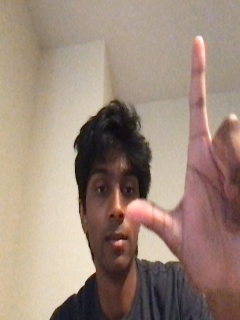

NameError: ignored

In [ ]:
import numpy as np
import cv2
from IPython.display import Image
from keras.preprocessing.image import img_to_array, load_img

try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))
  
from PIL import Image
# Preprocess image for model
img = Image.open(filename)
img = np.asarray(img)
# img = load_img(filename)
# img = img_to_array(img)
img = cv2.resize(img,(240,320))
print(img)
display(Image.fromarray(img, 'RGB'))
img = img.reshape(1,240,320,3)
output = model.predict(img)[0]
sign = class_names[np.argmax(output)]
print(sign, end="")